# Learning from the data

In the last notebook (5.3), we created the feature vector that we want to use to learn the conditions that lead to regulations. In this notebook, we will load the dataset, inspect it and gather some first correlations, select the most promising features, normalize and scale them, and finally run an ML algorithm on them.

In [59]:
import os.path
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import json
from IPython.display import clear_output
import random
import ast
from pandas.io.json import json_normalize, read_json
from datetime import datetime
from IPython.display import HTML
from sklearn import preprocessing


#Set some parameters for nicer visualizations
pd.set_option('display.expand_frame_repr', False) #do not wrap the printout of Pandas DataFrames
pd.set_option('display.precision', 2)
mp.rcParams['figure.figsize'] = (20, 12)
mp.pyplot.style.use = 'fivethirtyeight'
%matplotlib inline

In [60]:
dfmain = pd.read_csv('data/dffinal.csv', index_col=0)
dfmain['geojson'] = dfmain['geojson'].map(ast.literal_eval) #convert string to dict
dfmain['sta'] = pd.to_datetime(dfmain['sta'])
dfmain['end'] = pd.to_datetime(dfmain['end'])
dfmain['duration'] = pd.to_timedelta(dfmain['duration'])   
dfmain.head()

,icao,s,iata,wkt,geojson,sta,end,duration,rwys,wx,...,windSpeed,windGust,precipIntensity,precipProbability,storm,crosswind,cap,demand,ratio,regulated
0,LEAL,Place_Alicante_Elche_Airport,ALC,POINT (-0.558055579662323 38.282222747802734),"{'type': 'Point', 'coordinates': [-0.558055579...",2016-04-01,2016-04-01 00:59:59,00:59:59,280,"{'latitude': 38.28, 'longitude': -0.56, 'timez...",...,4.03,0.0,0.0,0.0,0,2.02,34,0.0,0.0,0
1,LEBL,Place_Barcelona_ElPrat_Airport,BCN,POINT (2.0783333778381348 41.29694366455078),"{'type': 'Point', 'coordinates': [2.0783333778...",2016-04-01,2016-04-01 00:59:59,00:59:59,250,"{'latitude': 41.3, 'longitude': 2.08, 'timezon...",...,4.28,0.0,0.0,0.0,0,2.20,48,0.0,0.0,0
2,LEBB,Place_Bilbao___Sondica,BIO,POINT (-2.910555601119995 43.301109313964844),"{'type': 'Point', 'coordinates': [-2.910555601...",2016-04-01,2016-04-01 00:59:59,00:59:59,300,"{'latitude': 43.3, 'longitude': -2.91, 'timezo...",...,3.58,0.0,0.0,0.0,0,1.79,22,0.0,0.0,0
3,LEMD,Place_Madrid_Barajas_Airport,MAD,POINT (-3.560833215713501 40.47222137451172),"{'type': 'Point', 'coordinates': [-3.560833215...",2016-04-01,2016-04-01 00:59:59,00:59:59,180,"{'latitude': 40.47, 'longitude': -3.56, 'timez...",...,5.04,0.0,0.0,0.0,0,0.79,38,0.0,0.0,0
4,LEMG,Place_Malaga_CostaDelSol_Airport,AGP,POINT (-4.499166488647461 36.67499923706055),"{'type': 'Point', 'coordinates': [-4.499166488...",2016-04-01,2016-04-01 00:59:59,00:59:59,320,"{'latitude': 36.67, 'longitude': -4.5, 'timezo...",...,6.55,0.0,0.0,0.0,0,3.27,37,0.0,0.0,0


# 1. Visualizing Feature to Label Correlations

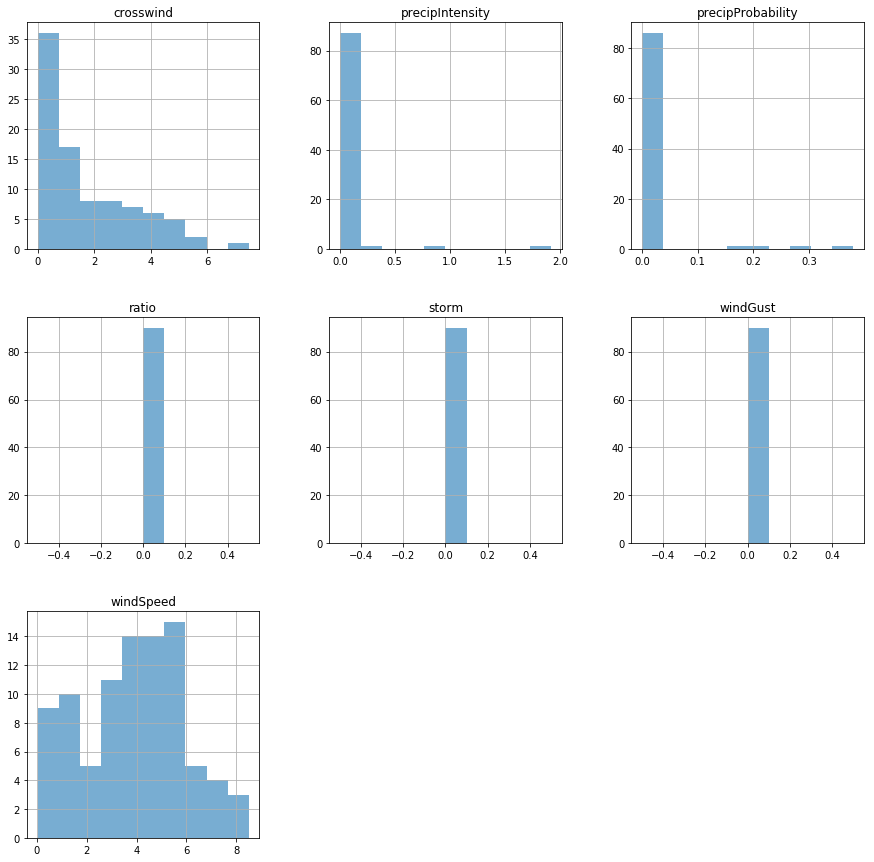

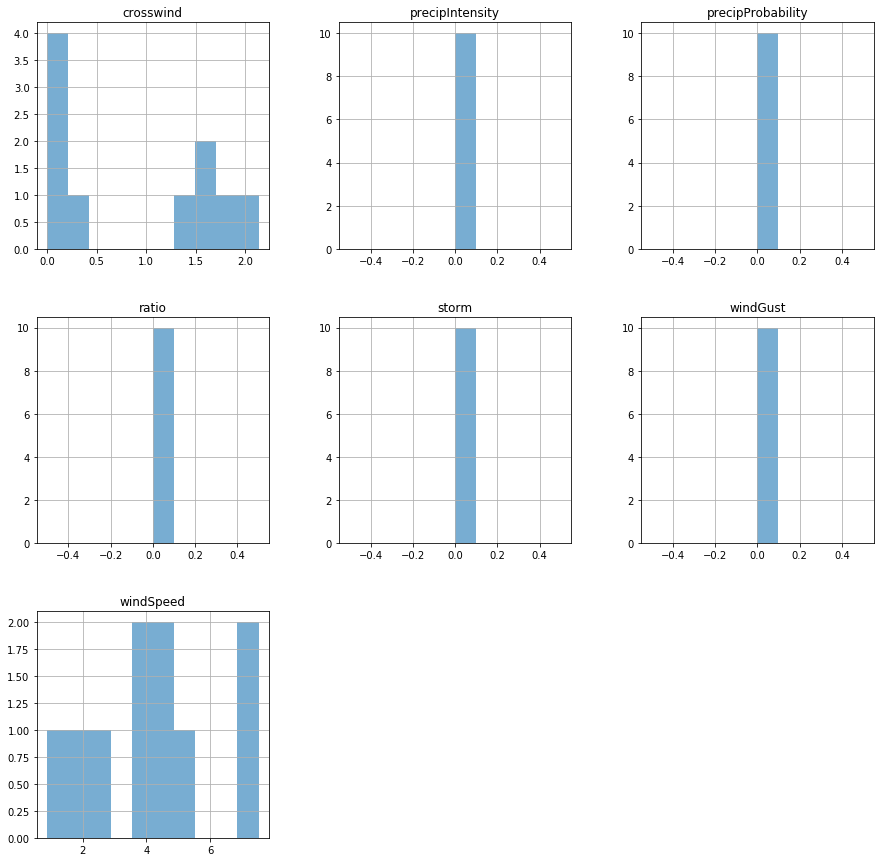

In [61]:
# Select only features, no referral columns
df_fl.groupby('regulated').hist(alpha=0.6, figsize=(15,15));

/home/joerg/anaconda3/envs/datacron1/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/home/joerg/anaconda3/envs/datacron1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


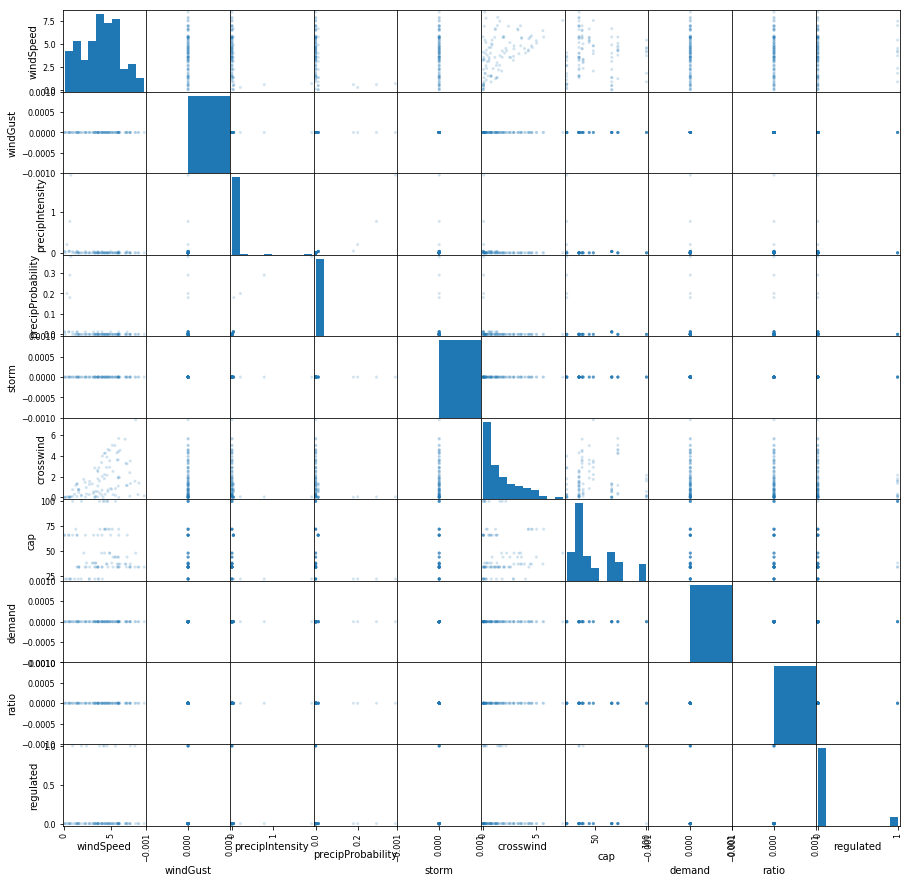

In [14]:
from pandas.plotting import scatter_matrix
dffeat.groupby('regulated')
scatter_matrix(dffeat, alpha=0.2, figsize=(10, 10));

From the above diagrams, we can conclude that....

/home/joerg/anaconda3/envs/datacron1/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


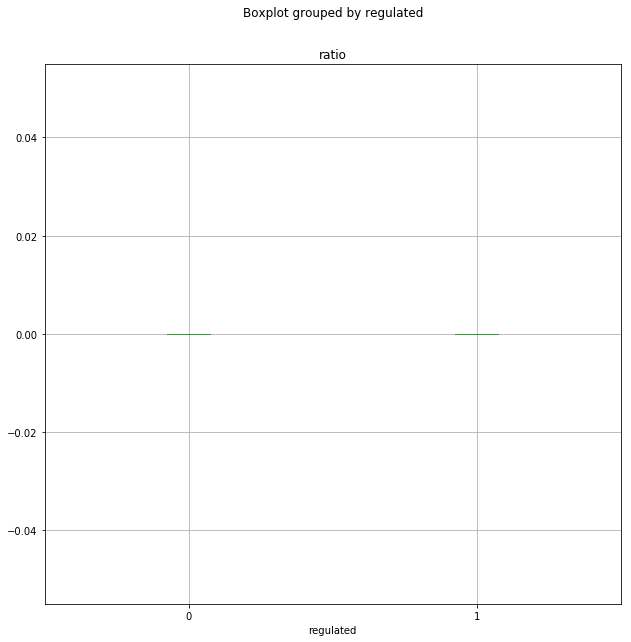

In [26]:
#dffeat.boxplot(column=['ratio'], by='regulated', figsize=(10,10));

# TODO

 - implementiere die Pipeline als Standardweg: Normalisierung, PCA, SVC.
 - du hast ein unbalanced problem. Dem musst du Rechnung tragen, und bei score() entsprechend nicht die accuracy nehmen, sondern precision and recall!

# 2. Feature Normalization

Feature normalization has the purpose of leveling different features into a comparable numerical dimension. While _scaling_ only levels the numerical range of the features, _normalization_ refers to a transformation that generates an input matrix where the features have 0 mean and equal variance across the observations. We will be using `sklearn` for this purpose. In `sklearn`, two different classes implement scaling and normalization, respectively: `MinMaxScaler` and `StandardScaler`. The scaling class operates as follows: $$ \frac{1}{2} $$

The normalization class operates as follows:

As described in the `sklearn` documentation, scaling is more common to preprocess data for Neural Nets, while normalization is being used for Support Vector Machines and alike.

In the follwoing code sections, $X$ will always denote features, and $y$ will denote the labels.

In [62]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm

X, y = np.array(df_fl[['windSpeed', 'crosswind', 'ratio']]),  np.array(df_fl['regulated'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

#note to self: instead of train_test_split, we can use kfold for cross-validation


#instantiate a normalizer. Beware to fit on train, and only tranform on test.
normer = preprocessing.Normalizer()
X_train_norm = normer.fit_transform(X_train)
X_test_norm  = normer.transform(X_test)

In [63]:
X_train_norm.shape, X_test_norm.shape, y_train.shape, y_test.shape

((70, 3), (30, 3), (70,), (30,))

# 3. Fitting a Support Vector Classifier

We will now use the prepared dataset to fit a SVC to the problem

In [65]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))


             precision    recall  f1-score   support

          0       0.97      1.00      0.98        29
          1       0.00      0.00      0.00         1

avg / total       0.93      0.97      0.95        30



/home/joerg/anaconda3/envs/datacron1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 4. Evaluating the results

fit a logistic regression model

clf_base = LogisticRegression()
grid = {'C': 10.0 ** np.arange(-2,3), penalty: {'11','12'}}

cv = KFold(X_train.shape[0], n_folds=5, shuffle=True, random_state=0)
clf = GridSearchCV(clf_base, grid, cv=cv, n_jobs=8, scoring='f1_macro')

clf.fit(X_train, y_train)

coef = clf.best_estimator_.coef_
intercept = clf.best_estimator_.intercept_



#Ausführlicher Testreport:
from sklearn.metrics import classification_report
print classification_report(y_test, clf.predict(X_test))



SMOTE oversampling technique:

 - paper lesen
 - ist eine datenorientierte resampling technik, um mit imbalance zu copen
 
 os = SMOTE(ratio=0.5, k=5, random_state=1)
 X_train_res, y_train_res = os.fit_sample(X_train, y_train)
 
 
.... danach hat man ein größeres Dataset und kann die ML Classifier ganz normal anwenden

 